Experience of memory used for the key equation when chunking vs whole matrix 

In [ ]:
import numpy as np
import time, psutil, os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch

from src.gpu import (gpu_memory_peak_mb,knm_full_mv_gpu, 
                     knm_block_mv_gpu, knm_block_mv_gpu_qr, 
                     upscale_heatmap)

## Figure 6 : Compute the memory/computationnal cost according to batch q and dataset size n


In [ ]:
# ============================================================
# EXPERIMENT PARAMETERS
# ============================================================

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

q_list = [500, 5000, 15000]
m = 1500
d = 20

n_values = np.unique(np.logspace(2, 5, 20).astype(int))
C = np.random.randn(m, d).astype(np.float32)
v = np.random.randn(m).astype(np.float32)

results_time_gpu = {q: [] for q in q_list}
results_mem_gpu  = {q: [] for q in q_list}

time_full_gpu = []
mem_full_gpu  = []

In [ ]:
for n in n_values:
    X = np.random.randn(n, d).astype(np.float32)

    print(f"\n=== n = {n} ===")

    if device.type == "cuda":
         torch.cuda.empty_cache()

    # full GPU, no chunking 
    if device.type == "cuda":
        torch.cuda.reset_peak_memory_stats()
        t0 = time.time()
        try:
            _, stats = knm_full_mv_gpu(X, C, v, device)
            t = stats["total_time"]
            peak_mem = gpu_memory_peak_mb(device)
            time_full_gpu.append(t)
            mem_full_gpu.append(peak_mem)
            print(f"  GPU FULL time={t:.4f}s  peak_mem={peak_mem:.2f}MB")
        except RuntimeError as e: # Out of memory
            print(f"  GPU FULL FAILED (OOM expected): {e}. Set time/mem to NaN.")
            time_full_gpu.append(np.nan)
            mem_full_gpu.append(np.nan)
            torch.cuda.empty_cache()
    else:
        time_full_gpu.append(np.nan)
        mem_full_gpu.append(np.nan)
        print("  GPU FULL skipped (CPU environment)")


    # ---------------- GPU BLOCK-WISE ----------------
    for q in q_list:
        if device.type == "cuda":
            torch.cuda.reset_peak_memory_stats()

        t0 = time.time()
        _, stats = knm_block_mv_gpu(X, C, v, device, q=q)
        t = stats["total_time"]
        peak_mem = gpu_memory_peak_mb(device)

        results_time_gpu[q].append(t)
        results_mem_gpu[q].append(peak_mem)

        print(f"  q={q:5d}  time={t:.4f}s  peak_mem={peak_mem:.2f}MB")

In [ ]:
plt.figure(figsize=(14,6))
colors = plt.cm.viridis(np.linspace(0,1,len(q_list)))
sizes_n = [5 + 1.4*np.log10(n) for n in n_values]
plt.style.use('ggplot')

# === Time === 
plt.subplot(1,2,1)

plt.plot(n_values, time_full_gpu, "-.o", color="blue", linewidth=2, markersize=6, label="GPU FULL Knm")
for q, color in zip(q_list, colors):
    plt.plot(n_values, results_time_gpu[q], "-", color=color, linewidth=2, label=f"GPU Chunking q={q}")
    for i, n in enumerate(n_values):
        plt.plot(n, results_time_gpu[q][i], "o", color=color, markersize=sizes_n[i])

plt.xscale("log")
plt.xlabel("Dataset Size n", fontsize=12)
plt.ylabel("Time (s)", fontsize=12)
plt.title("Knm·v Execution Time: GPU Chunking vs GPU Full", fontsize=14) # Translated title
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(frameon=True, loc='upper left')


# === Memory === 
plt.subplot(1,2,2)

plt.plot(n_values, mem_full_gpu, "-.o", color="blue", linewidth=2, markersize=6, label="GPU FULL Knm")

for q, color in zip(q_list, colors):
    plt.plot(n_values, results_mem_gpu[q], "-", color=color, linewidth=2, label=f"GPU Chunking q={q}")
    for i, n in enumerate(n_values):
        plt.plot(n, results_mem_gpu[q][i], "o", color=color, markersize=sizes_n[i])

plt.xscale("log")
plt.xlabel("Dataset Size n", fontsize=12) 
plt.ylabel("Peak Memory Usage (MB)", fontsize=12) 
plt.title("Peak Memory Usage: GPU Chunking vs GPU Full", fontsize=14) 
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(frameon=True, loc='upper left')
plt.tight_layout()
plt.savefig('memory_time.png')
plt.show()

## Figure 7 : Heatmaps of impact of q and r over memory/computationnal cost

In [ ]:
n = 50000
m = 5000
d = 20

s = d    # s = dimension batch for features (we keep equal to d)
X = np.random.randn(n, d).astype(np.float32)
C = np.random.randn(m, d).astype(np.float32)
v = np.random.randn(m).astype(np.float32)

q_list = np.unique(np.logspace(2, 4, 25).astype(int))   
r_list = np.unique(np.logspace(2, 3.7, 25).astype(int)) 

heat_time = np.zeros((len(q_list), len(r_list)))
heat_mem  = np.zeros((len(q_list), len(r_list)))


# -------------------------------------------------------
# MAIN GRID SEARCH
# -------------------------------------------------------
for iq, q in enumerate(q_list):
    for ir, r in enumerate(r_list):

        print(f"\n=== q={q}, r={r} ===")

        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

        try:
            _, stats = knm_block_mv_gpu_qr(X, C, v, device, q=q, r=r)
            t = stats["total_time"]
            mem = gpu_memory_peak_mb(device)

            heat_time[iq, ir] = t
            heat_mem[iq, ir]  = mem

            print(f"time={t:.4f}s  mem={mem:.1f}MB")

        except RuntimeError as e:
            print("OOM → NaN")
            heat_time[iq, ir] = np.nan
            heat_mem[iq, ir]  = np.nan
            torch.cuda.empty_cache()

In [ ]:
heat_time, q_new, r_new = upscale_heatmap(heat_time, q_list, r_list, factor=4)
heat_mem, _, _          = upscale_heatmap(heat_mem,  q_list, r_list, factor=4)


fig, axs = plt.subplots(1, 2, figsize=(18, 7))


# TIME HEATMAP (log color scale)
ax = axs[0]
ax.set_title("GPU Compute Time Heatmap (log scale)")
ax.set_xlabel("r (centers)")
ax.set_ylabel("q (batch size)")
ax.set_xscale("log")
ax.set_yscale("log")


mask_time = np.isfinite(heat_time) & (heat_time > 0)
vmin_t = heat_time[mask_time].min()
vmax_t = heat_time[mask_time].max()

pcm_time = ax.pcolormesh(
    r_new,
    q_new,
    heat_time,
    shading='gouraud',
    cmap='viridis',
    norm=LogNorm(vmin=vmin_t, vmax=vmax_t)
)

fig.colorbar(pcm_time, ax=ax, label="seconds (log scale)")



# MEMORY HEATMAP (log color scale)
ax = axs[1]
ax.set_title("GPU Peak Memory Heatmap (log scale)")
ax.set_xlabel("r (centers)")
ax.set_ylabel("q (batch size)")
ax.set_xscale("log")
ax.set_yscale("log")


mask_mem = np.isfinite(heat_mem) & (heat_mem > 0)
vmin_m = heat_mem[mask_mem].min()
vmax_m = heat_mem[mask_mem].max()

pcm_mem = ax.pcolormesh(
    r_new,
    q_new,
    heat_mem,
    shading='gouraud',
    cmap='magma',
    norm=LogNorm(vmin=vmin_m, vmax=vmax_m)
)

fig.colorbar(pcm_mem, ax=ax, label="MB (log scale)")

plt.tight_layout()
plt.savefig("heatmap.png")
plt.show()

## Figure 8 : Floating point precision

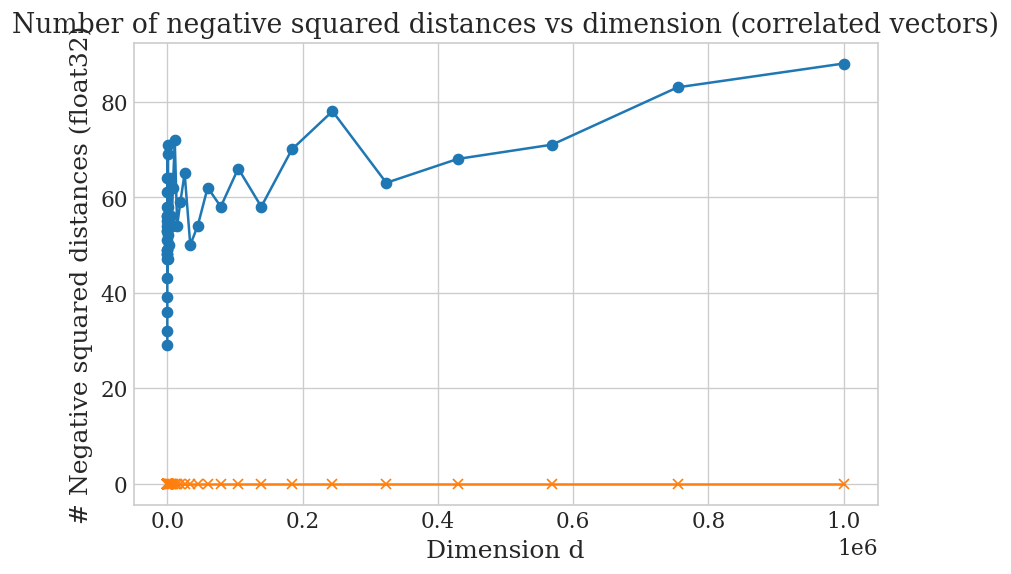

<Figure size 768x576 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dims = np.logspace(0, 6, num=50).astype(int)
num_pairs = 200
neg_counts_32 = []
neg_counts_64 = []

np.random.seed(0)
weighted = False

for d in dims:
    alpha = 10.0 / d
    count_neg_32 = 0
    count_neg_64 = 0 
    for _ in range(num_pairs):
        # Highly correlated vectors to trigger cancellation
        x64 = np.random.randn(d).astype(np.float64)
        if weighted : 
            eps = np.random.randn(d).astype(np.float64)
            y64 = np.sqrt(1 - alpha) * x64 + np.sqrt(alpha) * eps
        else : 
            noise = 1e-4 * np.random.randn(d).astype(np.float64)
            y64 = x64 + noise

        # float32 versions
        x32 = x64.astype(np.float32)
        y32 = y64.astype(np.float32)

        # squared distance float32
        dist32 = np.dot(x32, x32) - 2*np.dot(x32, y32) + np.dot(y32, y32)
        if dist32 < 0:
            count_neg_32 += 1
        
        dist64 = np.dot(x64, x64) - 2*np.dot(x64, y64) + np.dot(y64, y64)
        if dist64 < 0:
            count_neg_64 += 1

    neg_counts_32.append(count_neg_32)
    neg_counts_64.append(count_neg_64)

<>:31: SyntaxWarning: "\|" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\|"? A raw string is also an option.
<>:31: SyntaxWarning: "\|" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\|"? A raw string is also an option.
/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_86718/388846952.py:31: SyntaxWarning: "\|" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\|"? A raw string is also an option.
  ax.set_title("Negative $\|x - y\|^2$ occurrences vs dimension")


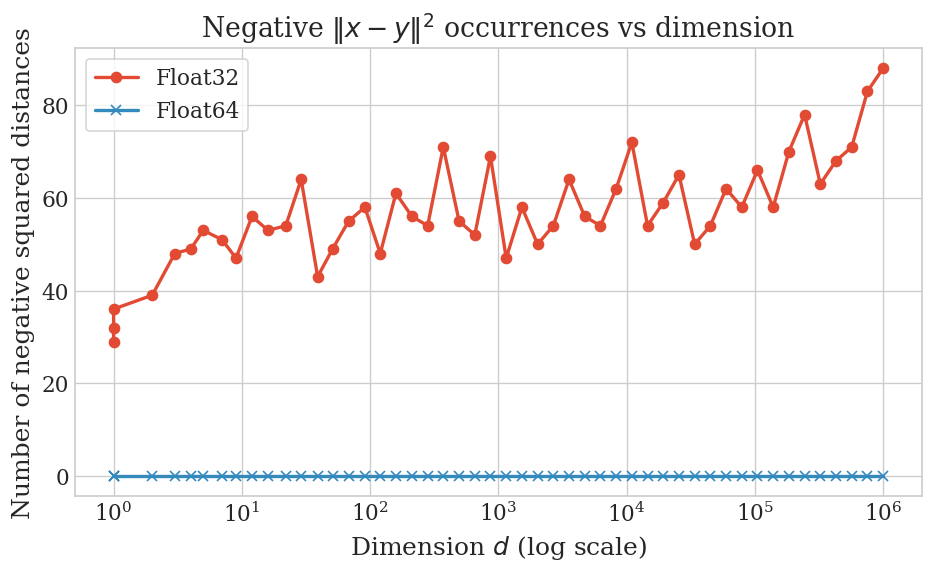

<Figure size 768x576 with 0 Axes>

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "legend.fontsize": 13,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "figure.dpi": 120,
})

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(dims, neg_counts_32, marker='o', markersize=6, linewidth=2,
        label="Float32", color="#E24A33")
ax.plot(dims, neg_counts_64, marker='x', markersize=6, linewidth=2,
        label="Float64", color="#348ABD")

ax.set_xscale("log")

ax.set_xlabel("Dimension $d$ (log scale)")
ax.set_ylabel("Number of negative squared distances")
ax.set_title("Negative $\|x - y\|^2$ occurrences vs dimension")
ax.legend(frameon=True, shadow=False)
plt.tight_layout()

plt.show()
plt.savefig("./floating_point_error.png")